In [2]:
from photo_utils import *
from datetime import datetime
from utils import *
import matplotlib.dates as mdates
import zarr
import cmocean

# Pull SunnyD Data

In [90]:
from my_secrets import API_USERNAME, API_PASSWORD

authorization = (API_USERNAME, API_PASSWORD)

In [128]:
# Choose sensor location e.g. 'Beaufort', 'Carolina Beach', 'Down East', 'New Bern'
# Or provide sensor ID e.g. ['CB_01', 'DE_02']
location = ['CB_03']
# location = 'Carolina Beach'

# Set the beginning and ending dates to pull data (YYYY, MM, DD)
total_min_date = datetime(2023, 12, 26)
total_max_date = datetime(2023, 12, 28)

In [129]:
sunnyd_data = get_sunnyd_data(authorization, location, total_min_date, total_max_date)

Here is your data, human. Sincerely, 🤖


In [130]:
sunnyd_data.to_csv('sunny_day_12272023_data.csv')

# Plot Water Levels

## Load Water Levels from SunnyD

In [131]:
sunnyd_data = pd.read_csv('sunny_day_12272023_data.csv')
sunnyd_data['date'] = pd.to_datetime(sunnyd_data['date'])

## Map Water Levels to Closest Image in Time

In [132]:
image_list = os.listdir('/home/rmccune/depth_mapping/data/CB03_12272023/orig_images')
image_list = sorted(image_list)
image_list[0]

'CAM_CB_03_20231227120027.jpg'

In [133]:
results = []

# Iterate over image filenames
for filename in image_list:
    # Extract the sensor id and timestamp
    sensor_id = extract_sensor_name(filename)[4:]
    timestamp = extract_timestamp(filename)

    timestamp = pytz.utc.localize(datetime.strptime(timestamp, "%Y%m%d%H%M%S"))
    
    # Filter the dataframe by sensor id
    filtered_df = sunnyd_data[sunnyd_data['sensor_ID'] == sensor_id]
    
    # Find the closest timestamp
    closest_row = filtered_df.iloc[(filtered_df['date'] - timestamp).abs().argsort()[:1]]
    
    # Append the result
    if not closest_row.empty:
        result = {
            'image_filename': filename,
            'closest_utc_time': closest_row['date'].values[0],
            'water_level': closest_row['road_water_level_adj'].values[0] * 0.3048,
            'sensor_water_level': (closest_row['sensor_water_level_adj'].values[0] - 3.05) * 0.3048
        }
        results.append(result)

# Convert the results to a dataframe
results_df = pd.DataFrame(results)

In [134]:
results_df.head()

,image_filename,closest_utc_time,water_level,sensor_water_level
0,CAM_CB_03_20231227120027.jpg,2023-12-27 11:58:26,-0.064293,-0.064293
1,CAM_CB_03_20231227120625.jpg,2023-12-27 12:04:26,-0.072726,-0.072726
2,CAM_CB_03_20231227121225.jpg,2023-12-27 12:10:26,-0.047607,-0.047607
3,CAM_CB_03_20231227121826.jpg,2023-12-27 12:16:26,-0.024026,-0.024026
4,CAM_CB_03_20231227122425.jpg,2023-12-27 12:22:26,0.001059,0.001059


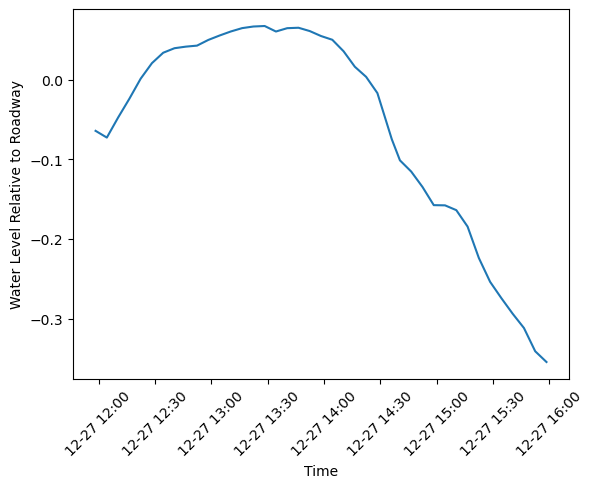

In [135]:
plt.plot(results_df['closest_utc_time'], results_df['water_level'])
# plt.plot(results_df['closest_utc_time'], np.ones(results_df['closest_utc_time'].shape)*(3.05*0.3048), c='r', linestyle='--')

plt.xlabel('Time')
plt.xticks(rotation=45)

plt.ylabel('Water Level Relative to Roadway')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Adjust format as needed

# Show the plot
plt.show()

## Virtual Sensors

In [136]:
# virtual_sensor_locs = [[1250, 3900],
#                        [750, 4400],
#                        [50, 3700],
#                        [86, 3547]]

virtual_sensor_locs = [[125, 390],
                       [75, 440],
                       [5, 370],
                       [9, 355]]

In [137]:
max_depth_list = []
timestamp_list = []
avg_depth_list = []
vs_1_depth_list = []
vs_2_depth_list = []
vs_3_depth_list = []
vs_4_depth_list = []

Calculate list of depths at virtual sensors over time, plus max and avg depths.

In [138]:
zarr_dir = '/home/rmccune/depth_mapping/data/zarr/CB03_12272023/depth_maps_95th_ponding'

for file_name in os.listdir(zarr_dir):
    if file_name.endswith('_ponding'):
        timestamp = extract_timestamp(file_name)
        zarr_store_path = os.path.join(zarr_dir, file_name)
        img_store = zarr.open(zarr_store_path)
        
        depth_map = img_store[:]
        
        max_elev_point_indices = np.unravel_index(np.nanargmin(depth_map), depth_map.shape)
    
        max_depth = np.nanmax(depth_map)
        avg_depth = np.nanmean(depth_map)

        vs_1_depth = depth_map[virtual_sensor_locs[0][1], virtual_sensor_locs[0][0]]
        vs_2_depth = depth_map[virtual_sensor_locs[1][1], virtual_sensor_locs[1][0]]
        vs_3_depth = depth_map[virtual_sensor_locs[2][1], virtual_sensor_locs[2][0]]
        vs_4_depth = depth_map[virtual_sensor_locs[3][1], virtual_sensor_locs[3][0]]

        timestamp_list.append(timestamp)
        max_depth_list.append(max_depth)
        avg_depth_list.append(avg_depth)
        vs_1_depth_list.append(vs_1_depth)
        vs_2_depth_list.append(vs_2_depth)
        vs_3_depth_list.append(vs_3_depth)
        # vs_4_depth_list.append(vs_4_depth)

In [139]:
len(timestamp_list)

41

Plot water levels

In [140]:
water_level_color = cmocean.cm.balance(0.2)
# roadway_elevation_color = cmocean.cm.deep(0.7)
max_depth_color = cmocean.cm.balance(0.9)
avg_depth_color = cmocean.cm.balance(0.6)
sensor_1_color = cmocean.cm.phase(0.1)
sensor_2_color = cmocean.cm.phase(0.3)
sensor_3_color = cmocean.cm.phase(0.5)

In [141]:
datetimes = pd.to_datetime(timestamp_list, utc=True)

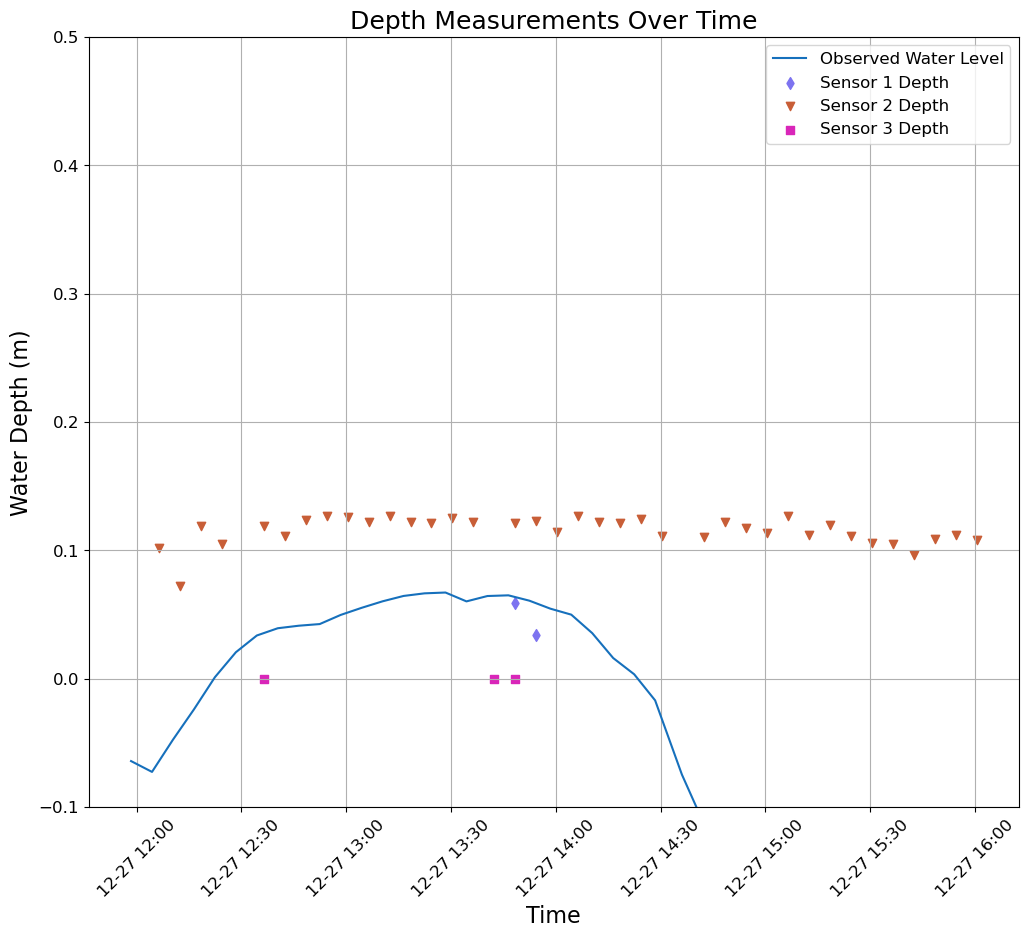

In [142]:
# Plotting the observed water level and roadway elevation

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)
fig, ax1 = plt.subplots(1, 1, figsize=(12, 10), sharex=True, sharey=True)


# Plotting the max and average depth
# ax1.plot(datetimes, max_depth_list, label='Maximum Depth', linestyle='-', color=max_depth_color)
# ax1.plot(datetimes, avg_depth_list, label='Average Depth', linestyle='-.', color=avg_depth_color)
ax1.plot(results_df['closest_utc_time'], results_df['water_level'], label='Observed Water Level', color=water_level_color)
# ax1.plot(results_df['closest_utc_time'], np.zeros(results_df['closest_utc_time'].shape), 
#          c='k', linestyle='--', label='Roadway Elevation')

# ax2.plot(results_df['closest_utc_time'], results_df['water_level'], label='Observed Water Level', color=water_level_color)
# ax2.plot(results_df['closest_utc_time'], np.zeros(results_df['closest_utc_time'].shape), 
#          c='k', linestyle='--', label='Roadway Elevation')

# Plotting the sensor readings

# ax1.plot(datetimes, vs_4_depth_list, label='Sensor 4 Depth', marker='x', color=sensor_3_color)

# ax1.plot(datetimes, vs_3_depth_list, label='Sensor 1 Depth', marker='d', color=sensor_3_color)
ax1.scatter(datetimes, vs_3_depth_list, label='Sensor 1 Depth', marker='d', color=sensor_3_color)
# ax1.plot(datetimes, vs_1_depth_list, label='Sensor 2 Depth',  marker='v', color=sensor_1_color)
ax1.scatter(datetimes, vs_1_depth_list, label='Sensor 2 Depth',  marker='v', color=sensor_1_color)
# ax1.plot(datetimes, vs_2_depth_list, label='Sensor 3 Depth', marker='s', color=sensor_2_color)
ax1.scatter(datetimes, vs_2_depth_list, label='Sensor 3 Depth', marker='s', color=sensor_2_color)

# Axis labels and title
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Water Depth (m)', fontsize=16)
# plt.ylim((0,0.6))
ax1.set_title('Depth Measurements Over Time', fontsize=18)
# ax2.set_title('Water Level From Virtual Sensor Locations Over Time')

# Adding gridlines
ax1.grid(True)
# ax2.grid(True)

# ax1.axvline(x=date_obj, color='k', linestyle='-', zorder=1)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Adjust format as needed
ax1.set_ylim(-0.1, 0.5)

# Adding legend outside of the figure bounds
# ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax1.legend(loc='best', fontsize=12)
# ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.savefig('water_level_obs_plot_12272023_95th_perc.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

# Plot Depth Maps